In [2]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from itertools import product
from typing import List
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 10

if "ipykernel_launcher.py" in sys.argv[0]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
if os.path.exists("/opt/conda/bin/ffmpeg"):
    plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
else:
    plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

colors = ["#5C49AC", "#1F9BCE", "#00B5CA", "#BED45F", "#F9E03B"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

from main import *

In [3]:
J = 0.1
agnetsCount = 500
Fs = np.linspace(0, 5, 30)
Ks = np.sort(np.concatenate([np.linspace(-1, 1, 30), [0]]))
TNum = 500

targetPath = f"./data/u1wLastStateJ{J}.h5"  # lastStateAfter  # lastStateRing  # lastState

totalPositionX = pd.read_hdf(targetPath, key="positionXs")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseThetas")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionXs = dict()
phaseThetas = dict()

models = [
    MobileDrive(agentsNum=500, K=K, J=0.1, F=F, dt=0.02) 
    for F in Fs
    for K in Ks
]
for model in tqdm(models):
    
    model.positionX = totalPositionX[idx]
    model.phaseTheta = totalPhaseTheta[idx]
    model.counts = 4990
    model.update_temp()
    t = (model.counts) * model.dt
    model.drivePosition = np.array([
        model.druveRadiusR * np.cos(model.driveAngularVelocityW * t),
        model.druveRadiusR * np.sin(model.driveAngularVelocityW * t)
    ])
    idx += 1

del totalPositionX, totalPhaseTheta

  0%|          | 0/930 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


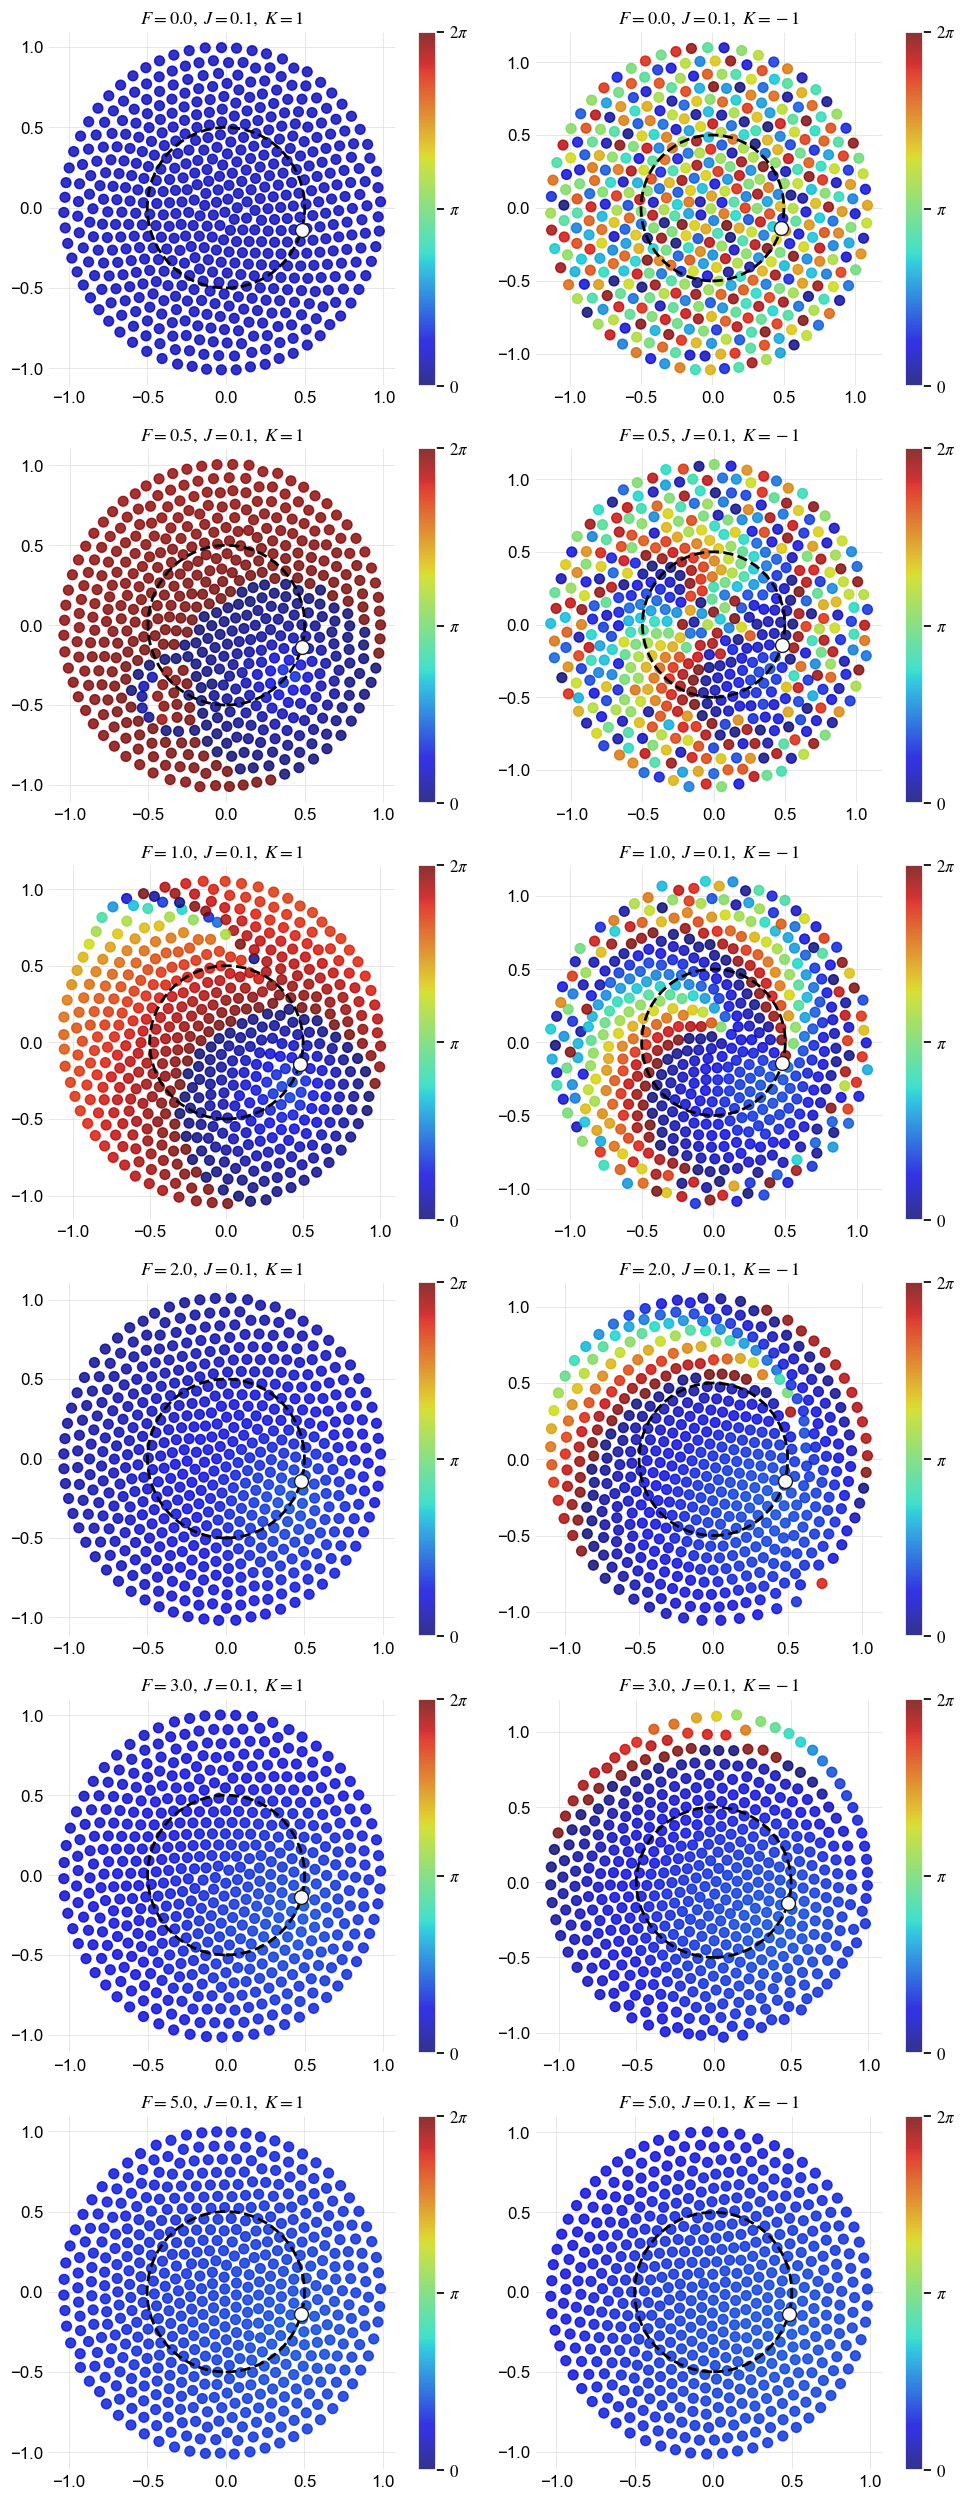

In [9]:
# For J=0.1
sns.set_theme(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

selectedF = [Fs[0], Fs[3], Fs[6], Fs[12], Fs[17], Fs[29]]
selectedFNum = len(selectedF)
selectedK = [1, -1]

fig, axs = plt.subplots(selectedFNum, 2, figsize=(10, selectedFNum * 4.2))
for row, F in enumerate(selectedF):
    for col, K in enumerate(selectedK):
        model = [m for m in models if m.F == F and m.K == K][0]
        model.update()
        ax = axs[row, col]
        ax.tick_params(direction='in', length=3)

        StateAnalysis.plot_last_state(model, ax)
        
        FinTitle = np.round(F) if F > 0.6 else np.round(F, 1)
        ax.set_title(f"$F={FinTitle:.1f},\ J={J},\ K={K}$")
        ax.set_xticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])


plt.tight_layout()
plt.savefig(f"./figs/formal/snapshotJ{J}.eps", bbox_inches='tight')

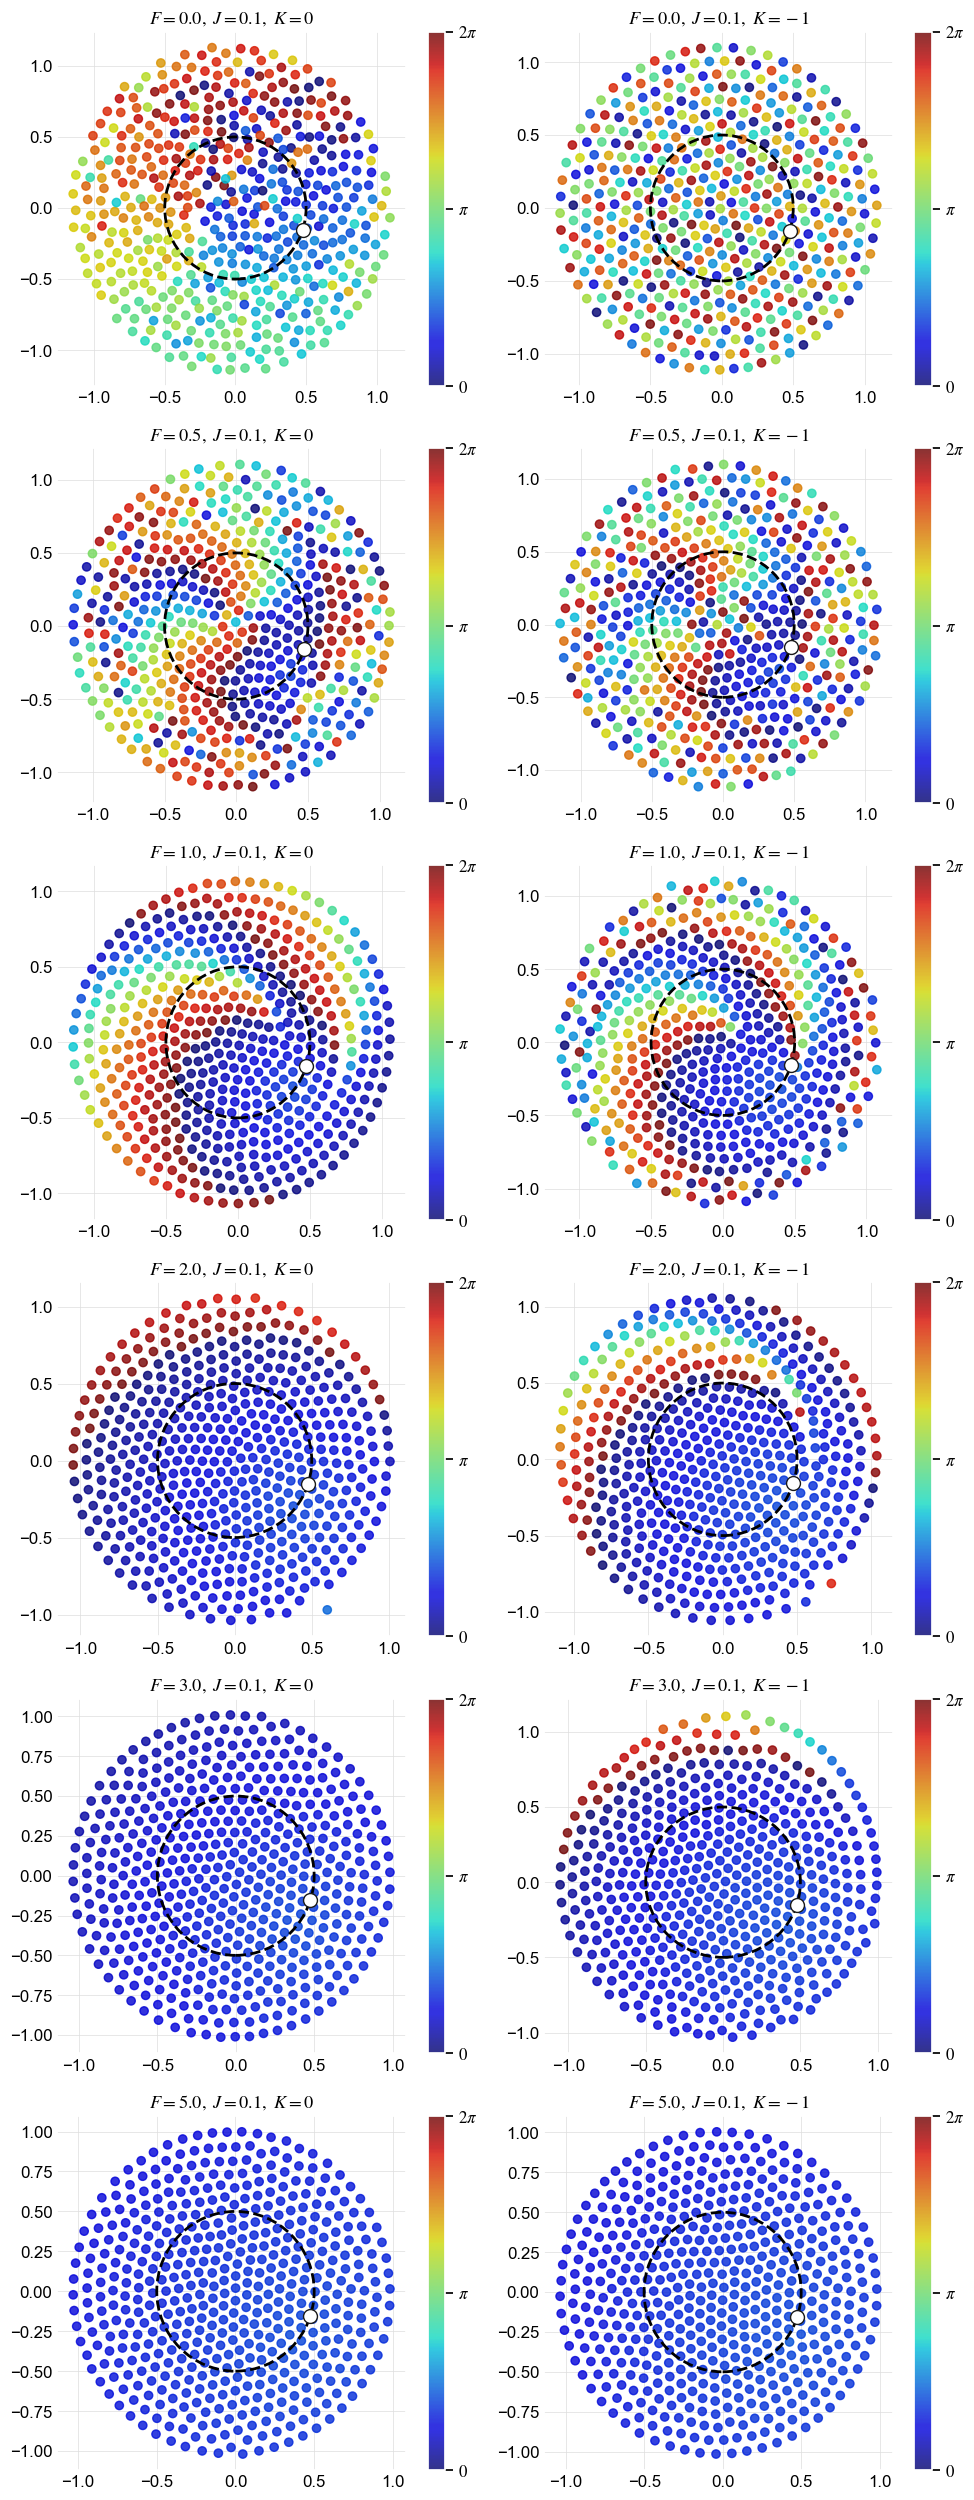

In [44]:
# For J = 1
sns.set_theme(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'

selectedF = [Fs[0], Fs[3], Fs[6], Fs[12], Fs[17], Fs[29]]
selectedFNum = len(selectedF)
selectedK = [0, -1]

fig, axs = plt.subplots(selectedFNum, 2, figsize=(10, selectedFNum * 4.2))
for row, F in enumerate(selectedF):
    for col, K in enumerate(selectedK):
        model = [m for m in models if m.F == F and m.K == K][0]
        ax = axs[row, col]
        ax.tick_params(direction='in', length=3)

        StateAnalysis.plot_last_state(model, ax)
        
        FinTitle = np.round(F) if F > 0.6 else np.round(F, 1)
        ax.set_title(f"$F={FinTitle:.1f},\ J={J},\ K={K}$")
        if np.abs(model.positionX).max() < 1:
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.set_xticks([-1, -0.5, 0, 0.5, 1])
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        

plt.tight_layout()
plt.savefig(f"./figs/formal/snapshotJ{J}.pdf", bbox_inches='tight')

In [27]:
class StateAnalysis:
    def __init__(self, model: MobileDrive, lookIndex: int = -1, showTqdm: bool = False):
        self.model = model
        self.lookIndex = lookIndex
        self.showTqdm = showTqdm
        
        targetPath = f"{self.model.savePath}/{self.model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        
        TNum = totalPositionX.shape[0] // self.model.agentsNum
        self.TNum = TNum
        self.tRange = np.arange(0, (TNum - 1) * model.shotsnaps, model.shotsnaps) * self.model.dt
        self.totalPositionX = totalPositionX.values.reshape(TNum, self.model.agentsNum, 2)
        self.totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, self.model.agentsNum)
        self.totalDrivePosition = np.array([
            model.druveRadiusR * np.cos(model.driveAngularVelocityW * self.tRange),
            model.druveRadiusR * np.sin(model.driveAngularVelocityW * self.tRange)
        ]).transpose(1, 0)
        self.totalDrivePhaseTheta = np.mod(model.driveThateVelocityOmega * self.tRange, 2 * np.pi)

        self.centersValue = None
        self.classesValue = None

        if self.showTqdm:
            self.iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            self.iterObject = range(1, self.totalPhaseTheta.shape[0])
            
    @staticmethod
    def calc_order_parameter_R(model: MobileDrive) -> float:
        return np.abs(np.sum(np.exp(1j * model.phaseTheta))) / model.agentsNum
    
    @staticmethod
    def calc_order_parameter_S(model: MobileDrive) -> float:
        phi = np.arctan2(model.positionX[:, 1], model.positionX[:, 0])
        Sadd = np.abs(np.sum(np.exp(1j * (phi + model.phaseTheta)))) / model.agentsNum
        Ssub = np.abs(np.sum(np.exp(1j * (phi - model.phaseTheta)))) / model.agentsNum
        return np.max([Sadd, Ssub])
    
    @staticmethod
    @nb.njit
    def _calc_pointX(Iatt, Irep, Fatt, Frep):
        dim = Iatt.shape[0]
        return np.sum(
            Iatt * Fatt.reshape((dim, dim, 1)) - Irep * Frep.reshape((dim, dim, 1)),
            axis=1
        ) / dim

    @staticmethod
    def calc_order_parameter_Vp(model: MobileDrive) -> float:
        Iatt, Irep, Fatt, Frep = model.Iatt, model.Irep, model.Fatt, model.Frep
        pointX = StateAnalysis._calc_pointX(Iatt, Irep, Fatt, Frep)
        phi = np.arctan2(pointX[:, 1], pointX[:, 0])
        return np.abs(np.sum(np.exp(1j * phi))) / model.agentsNum
    
    @staticmethod
    def calc_order_parameter_Ptr(model: MobileDrive) -> float:
        K, H, G, P = model.K, model.H, model.G, model.P
        dim = P.shape[0]
        pointTheta = K * np.sum(H * G, axis=1) / dim + P
        Ntr = np.abs(pointTheta - model.driveThateVelocityOmega) < 0.2 / model.dt * 0.1
        return Ntr.sum() / model.agentsNum
    
    @staticmethod
    def plot_last_state(model: MobileDrive, ax: plt.Axes, withColorBar: bool =True, s: float = 50, driveS: float = 100):
        t = model.counts * model.dt
        model.drivePosition = np.array([
            np.cos(model.driveThateVelocityOmega * t) * model.druveRadiusR,
            np.sin(model.driveThateVelocityOmega * t) * model.druveRadiusR
        ])
        ax.scatter(model.drivePosition[0], model.drivePosition[1], color="white", s=driveS, marker='o', edgecolors='k', zorder=10)
        sc = ax.scatter(model.positionX[:, 0], model.positionX[:, 1], s=s,
                    c=model.phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi)
        driveCircle = plt.Circle((0, 0), model.druveRadiusR, color='black', fill=False, lw=2, linestyle='--')
        ax.add_artist(driveCircle)
        if withColorBar:
            cbar = plt.colorbar(sc, ticks=[0, np.pi, 2*np.pi], ax=ax)
            cbar.ax.set_ylim(0, 2*np.pi)
            cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])

In [28]:
maps1 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps1.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_R(model)

maps2 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps2.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Ptr(model)

maps3 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps3.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_S(model)

maps4 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps4.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Vp(model)

  0%|          | 0/930 [00:00<?, ?it/s]

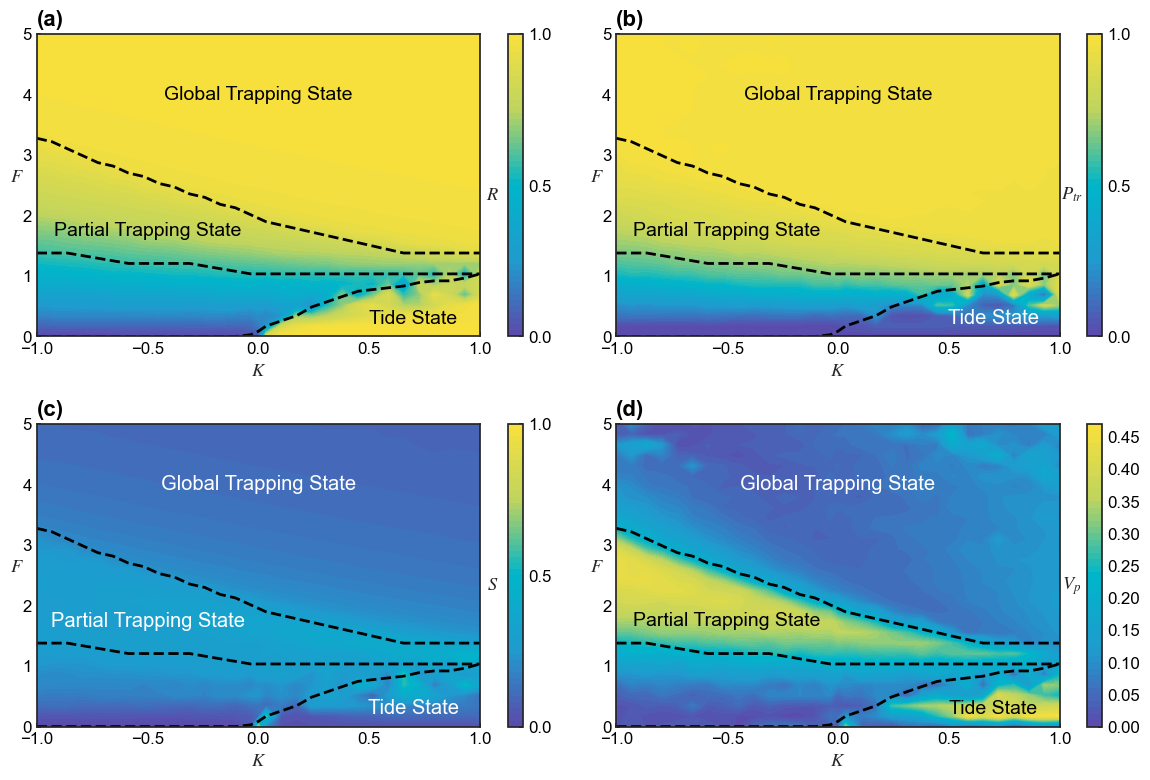

In [175]:
# For J=0.1
# get line1
Flocs = []
maps4Thres = 0.25
for K in Ks:
    selectedIdxs = maps4[(maps4[K] < maps4Thres) & (maps4[K].shift() >= maps4Thres) & (Fs > 1)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line1F = pd.Series(Flocs, index=Ks).rolling(3, center=True, min_periods=1).mean()
# get line2
Flocs = []
maps1Thres = 0.6
for K in Ks:
    reverseF = maps1[K][::-1]
    selectedIdxs = reverseF[(reverseF < maps1Thres) & (reverseF.shift() >= maps1Thres)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line2F = pd.Series(Flocs, index=Ks).rolling(4, center=True, min_periods=1).mean()
# get line3
Flocs = []
maps1Thres = 0.6
for K in Ks:
    Fvalues = maps1[K]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line3F = pd.Series(Flocs, index=Ks).rolling(6, center=True, min_periods=1).mean()

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'


levels = 50

cf1 = ax1.contourf(
    maps1.columns.values, maps1.index.values, 
    maps1.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
ax1.grid(False)
ax1.set_title("(a)", fontweight="bold", loc="left", fontsize=16)
cbar1 = plt.colorbar(cf1, ax=ax1, ticks=[0, 0.5, 1])
cbar1.ax.tick_params(direction='in', length=3)
cbar1.set_label(r"$R$", fontweight="bold", rotation=0)
cbar1.ax.yaxis.set_label_coords(-1, 0.5)
ax1.plot(line1F, color='black', linestyle="--", lw=2)
ax1.plot(line2F, color='black', linestyle="--", lw=2)
ax1.plot(line3F, color='black', linestyle="--", lw=2)
ax1.text(0, 4, "Global Trapping State", fontsize=14, color="black", ha="center", va="center")
ax1.text(-0.5, 1.75, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax1.text(0.7, 0.3, "Tide State", fontsize=14, color="black", ha="center", va="center")

stdMaps2 = maps2.copy()
stdMaps2.iloc[0, 0] = 0
stdMaps2.iloc[0, 1] = 1
cf2 = ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    stdMaps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    maps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.grid(False)
ax2.set_title("(b)", fontweight="bold", loc="left", fontsize=16)
cbar2 = plt.colorbar(cf2, ax=ax2, ticks=[0, 0.5, 1])
cbar2.ax.tick_params(direction='in', length=3)
cbar2.set_label(r"$P_{tr}$", fontweight="bold", rotation=0)
cbar2.ax.yaxis.set_label_coords(-1, 0.5)
ax2.plot(line1F, color='black', linestyle="--", lw=2)
ax2.plot(line2F, color='black', linestyle="--", lw=2)
ax2.plot(line3F, color='black', linestyle="--", lw=2)
ax2.text(0, 4, "Global Trapping State", fontsize=14, color="black", ha="center", va="center")
ax2.text(-0.5, 1.75, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax2.text(0.7, 0.3, "Tide State", fontsize=14.5, color="white", ha="center", va="center")

stdMaps3 = maps3.copy()
stdMaps3.iloc[0, 0] = 0
stdMaps3.iloc[0, 1] = 1
cf3 = ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    maps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.grid(False)
ax3.set_title("(c)", fontweight="bold", loc="left", fontsize=16)
cbar3 = plt.colorbar(cf3, ax=ax3, ticks=[0, 0.5, 1])
cbar3.ax.set_ylim(0, 1)
cbar3.ax.tick_params(direction='in', length=3)
cbar3.set_label(r"$S$", fontweight="bold", rotation=0)
cbar3.ax.yaxis.set_label_coords(-1, 0.5)
ax3.plot(line1F, color='black', linestyle="--", lw=2)
ax3.plot(line2F, color='black', linestyle="--", lw=2)
ax3.plot(line3F, color='black', linestyle="--", lw=2)
ax3.text(0, 4, "Global Trapping State", fontsize=14.5, color="white", ha="center", va="center")
ax3.text(-0.5, 1.75, "Partial Trapping State", fontsize=14.5, color="white", ha="center", va="center")
ax3.text(0.7, 0.3, "Tide State", fontsize=14.5, color="white", ha="center", va="center")

cf4 = ax4.contourf(
    maps4.columns.values, maps4.index.values, 
    maps4.values, levels=levels, # vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax4.set_xticks([-1, -0.5, 0, 0.5, 1])
ax4.grid(False)
ax4.set_title("(d)", fontweight="bold", loc="left", fontsize=16)
cbar4 = plt.colorbar(cf4, ax=ax4)
cbar4.ax.tick_params(direction='in', length=3)
cbar4.set_label(r"$V_p$", fontweight="bold", rotation=0, loc="center")
cbar4.ax.yaxis.set_label_coords(-1, 0.5)
ax4.plot(line1F, color='black', linestyle="--", lw=2)
ax4.plot(line2F, color='black', linestyle="--", lw=2)
ax4.plot(line3F, color='black', linestyle="--", lw=2)
ax4.text(0, 4, "Global Trapping State", fontsize=14.5, color="white", ha="center", va="center")
ax4.text(-0.5, 1.75, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax4.text(0.7, 0.3, "Tide State", fontsize=14, color="black", ha="center", va="center")

for ax in axs.flatten():
    ax.tick_params(direction='in', length=3)
    ax.set_ylabel(r"$F$", fontweight="bold", rotation=0)
    ax.set_xlabel(r"$K$", fontweight="bold")

plt.tight_layout()
plt.savefig(f"./figs/formal/orderParameterMapJ{J}.eps", bbox_inches="tight")

In [138]:
# get line1
Flocs = []
maps4Thres = 0.25
for K in Ks:
    selectedIdxs = maps4[(maps4[K] < maps4Thres) & (maps4[K].shift() >= maps4Thres) & (Fs > 1)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line1F = pd.Series(Flocs, index=Ks).rolling(3, center=True, min_periods=1).mean()
# get line2
Flocs = []
maps1Thres = 0.6
for K in Ks:
    reverseF = maps1[K][::-1]
    selectedIdxs = reverseF[(reverseF < maps1Thres) & (reverseF.shift() >= maps1Thres)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line2F = pd.Series(Flocs, index=Ks).rolling(4, center=True, min_periods=1).mean()
# get line3
Flocs = []
maps1Thres = 0.6
for K in Ks:
    Fvalues = maps1[K]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line3F = pd.Series(Flocs, index=Ks).rolling(5, center=True, min_periods=1).mean()

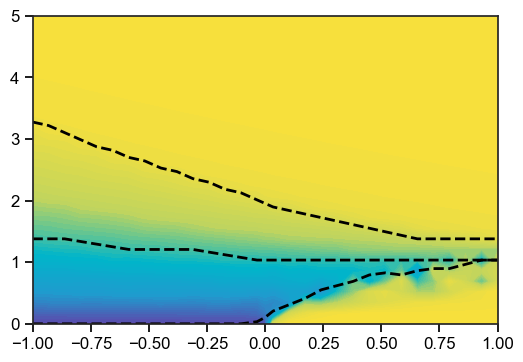

In [140]:
plt.figure(figsize=(6, 4))
plt.contourf(
    maps1.columns.values, maps1.index.values, 
    maps1.values, levels=levels, # vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
plt.plot(line1F, color='black', linestyle='--', lw=2)
plt.plot(line2F, color='black', linestyle='--', lw=2)
plt.plot(line3F, color='black', linestyle='--', lw=2)
# plt.scatter(Ks, line3F, color='black', s=10)

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


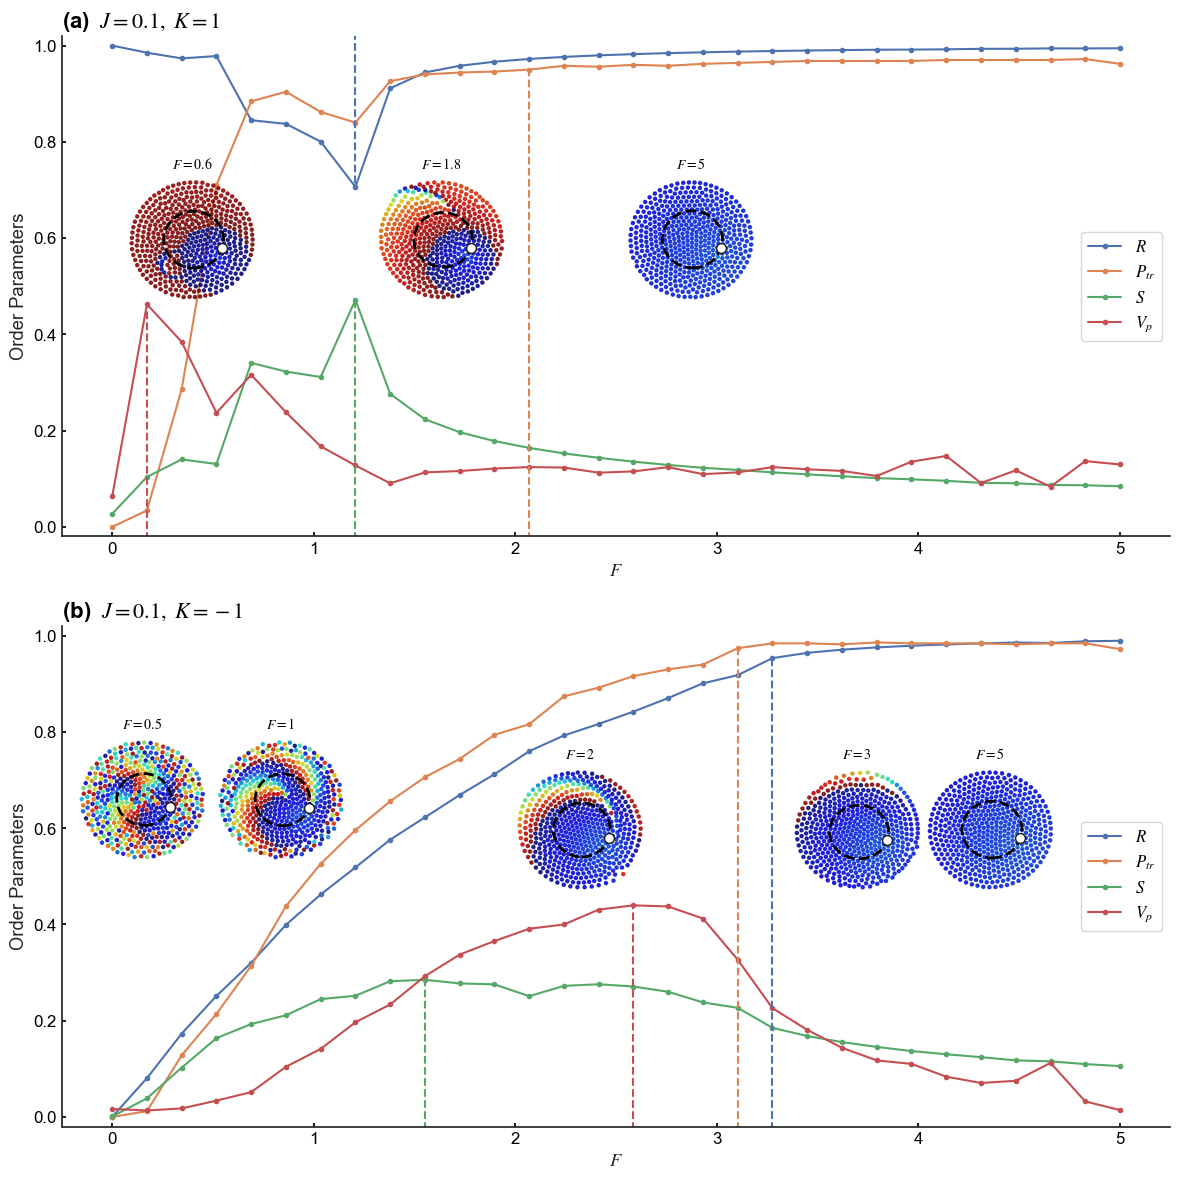

In [67]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from copy import deepcopy
sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
ax1, ax2 = axs.flatten()
maps1[1].plot(ax=ax1, marker='.', label=r"$R$")
maps2[1].plot(ax=ax1, marker='.', label=r"$P_{tr}$")
maps3[1].plot(ax=ax1, marker='.', label=r"$S$")
maps4[1].plot(ax=ax1, marker='.', label=r"$V_p$")
# ax1.axvline(Fs[7], color='black', lw=1, linestyle='--')
# ax1.axvline(Fs[12], color='black', lw=1, linestyle='--')
xShift = 0
yloc = 0.45
wide = 0.6
axTide = inset_axes(ax1, width="20%", height="42%", loc='lower left',
                    bbox_to_anchor=(0.05 + xShift, yloc, wide, wide),
                    bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[3] and m.K == 1][0]
StateAnalysis.plot_last_state(model, axTide, withColorBar=False, s=5, driveS=50)
axTide.set_title(r"$F=0.6$", fontweight="bold", fontsize=10)
axPaTrap = inset_axes(ax1, width="20%", height="42%", loc='lower left',
                    bbox_to_anchor=(0.275 + xShift, yloc, wide, wide),
                    bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[6] and m.K == 1][0]
StateAnalysis.plot_last_state(model, axPaTrap, withColorBar=False, s=5, driveS=50)
axPaTrap.set_title(r"$F=1.8$", fontweight="bold", fontsize=10)
axGlTrap = inset_axes(ax1, width="20%", height="42%", loc='lower left',
                    bbox_to_anchor=(0.5 + xShift, yloc, wide, wide),
                    bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[29] and m.K == 1][0]
StateAnalysis.plot_last_state(model, axGlTrap, withColorBar=False, s=5, driveS=50)
axGlTrap.set_title(r"$F=5$", fontweight="bold", fontsize=10)
ax1.set_title("(a)" + r"$\ \ J=0.1,\ K=1$", fontweight="bold", loc="left", fontsize=16)
ax1.plot([maps1[1].idxmin(), maps1[1].idxmin()], [1.05, maps1[1].min()], color="C0", linestyle="--")
ax1.plot([Fs[12], Fs[12]], [-0.05, maps2[1][Fs[12]]], color="C1", linestyle="--")
ax1.plot([maps3[1].idxmax(), maps3[1].idxmax()], [-0.05, maps3[1].max()], color="C2", linestyle="--")
ax1.plot([maps4[1].idxmax(), maps4[1].idxmax()], [-0.05, maps4[1].max()], color="C3", linestyle="--")
ax1.set_ylim(-0.02, 1.02)

maps1[-1].plot(ax=ax2, marker='.', label=r"$R$")
maps2[-1].plot(ax=ax2, marker='.', label=r"$P_{tr}$")
maps3[-1].plot(ax=ax2, marker='.', label=r"$S$")
maps4[-1].plot(ax=ax2, marker='.', label=r"$V_p$")
# ax2.axvline(0.5, color='black', lw=1, linestyle='--')
# ax2.axvline(3.5, color='black', lw=1, linestyle='--')
ax21 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.005, 0.51, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[3] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax21, withColorBar=False, s=5, driveS=50)
ax21.set_title(r"$F=0.5$", fontweight="bold", fontsize=10)
ax22 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.13, 0.51, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[6] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax22, withColorBar=False, s=5, driveS=50)
ax22.set_title(r"$F=1$", fontweight="bold", fontsize=10)
ax23 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.4, 0.45, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[12] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax23, withColorBar=False, s=5, driveS=50)
ax23.set_title(r"$F=2$", fontweight="bold", fontsize=10)
ax24 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.65, 0.45, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[17] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax24, withColorBar=False, s=5, driveS=50)
ax24.set_title(r"$F=3$", fontweight="bold", fontsize=10)
ax25 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.77, 0.45, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[29] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax25, withColorBar=False, s=5, driveS=50)
ax25.set_title(r"$F=5$", fontweight="bold", fontsize=10)
ax2.set_title("(b)" + r"$\ \ J=0.1,\ K=-1$", fontweight="bold", loc="left", fontsize=16)
ax2.plot([Fs[19], Fs[19]], [-0.05, maps1[-1][Fs[19]]], color="C0", linestyle="--")
ax2.plot([Fs[18], Fs[18]], [-0.05, maps2[-1][Fs[18]]], color="C1", linestyle="--")
ax2.plot([maps3[-1].idxmax(), maps3[-1].idxmax()], [-0.05, maps3[-1].max()], color="C2", linestyle="--")
ax2.plot([maps4[-1].idxmax(), maps4[-1].idxmax()], [-0.05, maps4[-1].max()], color="C3", linestyle="--")
ax2.set_ylim(-0.02, 1.02)

for ax in axs.flatten():
    ax.set_xlabel(r"$F$", fontweight="bold")
    ax.set_ylabel("Order Parameters")
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.grid(False)
    ax.legend(loc="center right")
for subAx in [axTide, axPaTrap, axGlTrap, ax21, ax22, ax23, ax24, ax25]:
    subAx.set_xticks([])
    subAx.set_yticks([])
    subAx.patch.set_alpha(0)
    subAx.spines['right'].set_visible(False)
    subAx.spines['top'].set_visible(False)
    subAx.spines['bottom'].set_visible(False)
    subAx.spines['left'].set_visible(False)
    subAx.grid(False)

plt.tight_layout()
plt.savefig(f"./figs/formal/orderParameterPlotJ{J}.eps", bbox_inches="tight")

In [64]:
opK1 = pd.concat([
    maps1[1],
    maps2[1],
    maps3[1],
    maps4[1]
], axis=1, keys=["R", "P_tr", "S", "V_p"])
opK1.index.name = "F"
opK1.to_excel(f"./figs/formal/orderParameterPlotJ{J}K1.xlsx")
opK_1 = pd.concat([
    maps1[-1],
    maps2[-1],
    maps3[-1],
    maps4[-1]
], axis=1, keys=["R", "P_tr", "S", "V_p"])
opK_1.index.name = "F"
opK_1.to_excel(f"./figs/formal/orderParameterPlotJ{J}K-1.xlsx")